    # Strava Leaderboard, Weather Analysis

In [1]:
import os
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [2]:
df = pd.read_csv("leaderboards_weather_random_sample.csv")
df.rename(columns={'Segement Direction': 'segment_direction'}, inplace=True)

In [3]:
df.shape

(500, 20)

In [4]:
df.head()

,_id,DryBulbFarenheit,DewPointFarenheit,RelativeHumidity,WindSpeed,WindDirection,HourlyPrecip,segment_id,effort_id,WBAN,distance,average_watts,rank,moving_time,elapsed_time,average_hr,athlete_gender,neighborhood_index,start_date_local,segment_direction
0,93193_20110514_1053,65,36,34,5,VR,,681150,63414631,93193,1203.3,NaN,10,406,406,NaN,M,0,2011-05-14T10:51:38Z,341.478249
1,93193_20110604_0753,59,52,78,3,350,0.02,681150,19669799,93193,1177.0,NaN,26,375,561,146.5,M,0,2011-06-04T07:25:30Z,341.478249
2,93193_20130316_1253,75,53,46,3,290,,681150,762764413,93193,1215.8,182.3,11,413,413,159.5,M,0,2013-03-16T12:36:21Z,341.478249
3,93193_20141229_1153,50,37,61,6,150,,681150,5525892980,93193,1198.3,193.2,17,460,460,NaN,M,0,2014-12-29T11:29:58Z,341.478249
4,93193_20120204_1353,66,27,23,5,280,,681150,71231846,93193,1211.5,149.0,20,479,479,139.7,M,0,2012-02-04T13:21:13Z,341.478249


In [5]:
df["RelativeHumidity"] = df["RelativeHumidity"].convert_objects(convert_numeric=True)
df["WindSpeed"] = df["WindSpeed"].convert_objects(convert_numeric=True)
df["WindDirection"] = df["WindDirection"].convert_objects(convert_numeric=True)
df["HourlyPrecip"] = df["HourlyPrecip"].convert_objects(convert_numeric=True)

In [6]:
df.describe()

,DryBulbFarenheit,RelativeHumidity,WindSpeed,WindDirection,HourlyPrecip,segment_id,effort_id,WBAN,distance,average_watts,rank,moving_time,elapsed_time,average_hr,neighborhood_index,segment_direction
count,295.000000,293.000000,284.000000,263.000000,3.000000e+00,500.000000,5.000000e+02,500.000000,500.000000,443.000000,500.000000,500.000000,500.000000,164.000000,500,500.000000
mean,67.932203,49.843003,7.158451,187.946768,2.000000e-02,4360553.840000,3.352888e+09,33808.400000,3368.362600,184.075169,389.898000,649.816000,1016.622000,147.476220,0,203.940973
std,9.497698,22.841681,5.472666,122.135753,3.292723e-10,2670463.255497,1.871470e+09,30170.330813,4192.844748,93.183143,1073.927989,695.851914,2466.470274,19.947664,0,88.316163
min,37.000000,3.000000,0.000000,0.000000,2.000000e-02,637242.000000,1.344059e+07,135.000000,125.600000,0.000000,1.000000,20.000000,20.000000,67.500000,0,0.437276
25%,61.000000,33.000000,3.000000,80.000000,2.000000e-02,1372305.000000,1.710002e+09,23129.000000,1141.950000,130.650000,9.000000,176.000000,177.000000,136.575000,0,128.072236
50%,68.000000,52.000000,6.500000,230.000000,2.000000e-02,4607868.000000,3.556940e+09,23713.000000,1953.350000,175.000000,44.500000,368.000000,396.500000,149.250000,0,207.757294
75%,73.500000,64.000000,10.000000,290.000000,2.000000e-02,6520806.000000,4.833961e+09,25507.000000,3754.750000,227.100000,270.250000,919.250000,1000.250000,159.725000,0,266.989330
max,100.000000,97.000000,30.000000,360.000000,2.000000e-02,8746651.000000,6.669280e+09,94276.000000,23441.900000,782.700000,8445.000000,4312.000000,17436.000000,179.900000,0,350.399850


In [7]:
df.dtypes


_id                    object
DryBulbFarenheit      float64
DewPointFarenheit      object
RelativeHumidity      float64
WindSpeed             float64
WindDirection         float64
HourlyPrecip          float64
segment_id              int64
effort_id               int64
WBAN                    int64
distance              float64
average_watts         float64
rank                    int64
moving_time             int64
elapsed_time            int64
average_hr            float64
athlete_gender         object
neighborhood_index      int64
start_date_local       object
segment_direction     float64
dtype: object

In [8]:
df["speed"] = (df["distance"] / (1609.344 * df["moving_time"])) * 3600

In [9]:
#headwind and crosswind speed calculated from: https://www.ivao.aero/training/documentation/books/PP_ADC_Headwind_croswind_calc.pdf
df['alpha'] = np.radians(df["WindDirection"]) - np.radians(df["segment_direction"])
df["CrossWindSpeed"] = df["WindSpeed"]*np.sin(df["alpha"])
df["HeadWindSpeed"] = df["WindSpeed"]*np.cos(df["alpha"])


In [10]:
df[0:10]

,_id,DryBulbFarenheit,DewPointFarenheit,RelativeHumidity,WindSpeed,WindDirection,HourlyPrecip,segment_id,effort_id,WBAN,...,elapsed_time,average_hr,athlete_gender,neighborhood_index,start_date_local,segment_direction,speed,alpha,CrossWindSpeed,HeadWindSpeed
0,93193_20110514_1053,65,36,34,5,NaN,NaN,681150,63414631,93193,...,406,NaN,M,0,2011-05-14T10:51:38Z,341.478249,6.629816,NaN,NaN,NaN
1,93193_20110604_0753,59,52,78,3,350,0.02,681150,19669799,93193,...,561,146.5,M,0,2011-06-04T07:25:30Z,341.478249,7.020997,0.148733,0.444555,2.966879
2,93193_20130316_1253,75,53,46,3,290,NaN,681150,762764413,93193,...,413,159.5,M,0,2013-03-16T12:36:21Z,341.478249,6.585150,-0.898465,-2.347115,1.868435
3,93193_20141229_1153,50,37,61,6,150,NaN,681150,5525892980,93193,...,460,NaN,M,0,2014-12-29T11:29:58Z,341.478249,5.827219,-3.341926,1.193975,-5.880002
4,93193_20120204_1353,66,27,23,5,280,NaN,681150,71231846,93193,...,479,139.7,M,0,2012-02-04T13:21:13Z,341.478249,5.657721,-1.072998,-4.393180,2.387462
5,93193_20130316_1253,75,53,46,3,290,NaN,681150,764011235,93193,...,551,134.1,M,0,2013-03-16T12:37:34Z,341.478249,4.877008,-0.898465,-2.347115,1.868435
6,93193_20140503_1253,85,44,24,0,0,NaN,681150,3114987859,93193,...,532,NaN,M,0,2014-05-03T12:47:32Z,341.478249,4.984331,-5.959920,0.000000,0.000000
7,93193_20150208_1153,69,59,71,14,130,NaN,681150,5935058918,93193,...,331,139.0,M,0,2015-02-08T11:06:02Z,341.478249,7.958357,-3.690992,7.310448,-11.939738
8,93193_20110604_0753,59,52,78,3,350,0.02,681150,19669799,93193,...,561,146.5,M,0,2011-06-04T07:25:30Z,341.478249,7.020997,0.148733,0.444555,2.966879
9,93193_20150208_1153,69,59,71,14,130,NaN,681150,5926028155,93193,...,562,NaN,NaN,0,2015-02-08T11:10:57Z,341.478249,7.161101,-3.690992,7.310448,-11.939738


In [11]:
#Calculate OLS for segment speed related to headwind speed
model1 = smf.ols(formula='speed ~ HeadWindSpeed', data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.763
Date:                Sun, 03 May 2015   Prob (F-statistic):            0.00572
Time:                        10:44:22   Log-Likelihood:                -876.69
No. Observations:                 263   AIC:                             1757.
Df Residuals:                     261   BIC:                             1765.
Df Model:                           1                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        15.3839      0.420     36.638      0.000        14.557    16.211
HeadWindSpeed    -0.1928      0.069     -2.786      0.006        -0.329    -0.057
==============================================================================
Omnibus:                        5.818   Durbin-Watson:                   0.665
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.165
Skew:                           0.271   Prob(JB):                       0.0756
Kurtosis:                       2.580   Cond. No.                         6.07
==============================================================================
"""

In [12]:
#Now let's add cross wind speed
model2 = smf.ols(formula='speed ~ HeadWindSpeed + CrossWindSpeed', data=df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     7.661
Date:                Sun, 03 May 2015   Prob (F-statistic):           0.000585
Time:                        10:44:22   Log-Likelihood:                -873.02
No. Observations:                 263   AIC:                             1752.
Df Residuals:                     260   BIC:                             1763.
Df Model:                           2                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         15.4977      0.417     37.167      0.000        14.677    16.319
HeadWindSpeed     -0.1797      0.069     -2.622      0.009        -0.315    -0.045
CrossWindSpeed    -0.1616      0.060     -2.715      0.007        -0.279    -0.044
==============================================================================
Omnibus:                        5.501   Durbin-Watson:                   0.716
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.453
Skew:                           0.317   Prob(JB):                       0.0655
Kurtosis:                       2.690   Cond. No.                         7.11
==============================================================================
"""

In [13]:
#Now let's see if temp has an effect on speed
model2 = smf.ols(formula='speed ~ DryBulbFarenheit', data=df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5059
Date:                Sun, 03 May 2015   Prob (F-statistic):              0.477
Time:                        10:44:22   Log-Likelihood:                -987.33
No. Observations:                 295   AIC:                             1979.
Df Residuals:                     293   BIC:                             1986.
Df Model:                           1                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           12.8175      2.906      4.411      0.000         7.099    18.536
DryBulbFarenheit     0.0301      0.042      0.711      0.477        -0.053     0.114
==============================================================================
Omnibus:                       10.497   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.040
Skew:                           0.460   Prob(JB):                      0.00401
Kurtosis:                       2.773   Cond. No.                         496.
==============================================================================
"""

In [14]:
# Now Putting it All Together
model1 = smf.ols(formula='speed ~ athlete_gender + DryBulbFarenheit + HeadWindSpeed + CrossWindSpeed', data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     4.626
Date:                Sun, 03 May 2015   Prob (F-statistic):            0.00128
Time:                        10:44:22   Log-Likelihood:                -827.85
No. Observations:                 254   AIC:                             1666.
Df Residuals:                     249   BIC:                             1683.
Df Model:                           4                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              14.6635      3.121      4.698      0.000         8.516    20.811
athlete_gender[T.M]     2.6113      1.322      1.975      0.049         0.008     5.215
DryBulbFarenheit       -0.0253      0.043     -0.582      0.561        -0.111     0.060
HeadWindSpeed          -0.0733      0.070     -1.054      0.293        -0.210     0.064
CrossWindSpeed         -0.2094      0.058     -3.591      0.000        -0.324    -0.095
==============================================================================
Omnibus:                       16.780   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.869
Skew:                           0.110   Prob(JB):                       0.0322
Kurtosis:                       2.225   Cond. No.                         536.
==============================================================================
"""

/Users/ssatpati/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


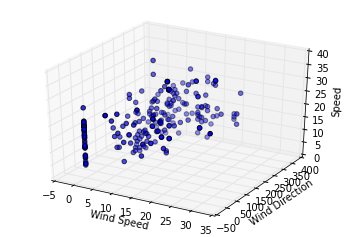

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
ax.scatter(df["WindSpeed"], df["WindDirection"], df["speed"])
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Wind Direction')
ax.set_zlabel('Speed')
#fig.add_subplot(df["WindSpeed"], df["WindDirection"], df["speed"], projection='3d')
fig.show()